<p style="font-weight:bold;text-align:center;font-size:25px;">Tutorial</p>
<p style="font-weight:600;text-align:center;font-size:20px;">Como utilizar a API da Área de Transparência do Portal do SNS</p>

Este artigo demonstra a obtenção e exploração de <a href="https://transparencia.sns.gov.pt/explore/?sort=title">dados disponibilizados</a> pelo <a href="https://www.sns.gov.pt/">Serviço Nacional de Saúde</a>, nomeadamente:

* Mostra como obter dados utilizando a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">API</a> disponibilizada pela área de <a href="https://www.sns.gov.pt/transparencia/">Transparência do Portal do Serviço Nacional de Saúde</a>;
* Analisa a distribuição de população e instituições hospitalares pelas diversas regiões de Portugal Continental;
* Ilustra o impacto do COVID-19 no Sistema Nacional de Saúde através da variação mensal no número de Consultas Médicas Hospitalares antes e durante a pandemia, partindo da análise detalhado dos dados relativos ao Instituto Português Oncologia de Lisboa, EPE e seguindo para o panorama geral das instituições de Portugal Continental.

Este artigo está disponível como um notebook que pode ser obtido e executado gratuitamente online:
<br>
 
<div align="center">
<a href="https://github.com/zevarela/dssg/blob/main/Tutorial_SNS_2021-09.ipynb" role="button" target="_blank"><img class="notebook-badge-image" src="assets/github.svg" alt="View On GitHub"></a>
<a href="https://mybinder.org/v2/gh/zevarela/dssg/master?filepath=Tutorial_SNS_2021-09.ipynb" target="_blank"><img src="assets/binder.svg" alt="Open In Binder"></a> 
<a href="https://colab.research.google.com/github/zevarela/dssg/blob/master/Tutorial_SNS_2021-09.ipynb" target="_blank"><img src="assets/colab.svg" alt="Open In Colab"></a>
</div>

## Índice

 1. [Introdução](#1.-Introdução)
   1. [O que é uma API?](#1.A.-O-que-é-uma-API?)
   2. [Que operações estão disponíveis?](#1.B.-Que-operações-estão-disponíveis?)
   3. [Instalação de bibliotecas](#1.C.-Instalação-de-bibliotecas)
 2. [Consultas Médicas Hospitalares](#2.-Consultas-Médicas-Hospitalares)
   1. [Obter os dados com odsclient](#2.A.-Obter-os-dados-com-odsclient)
   2. [Distribuição das instituições por região](#2.B.-Distribuição-das-instituições-por-região)
   3. [Distribuição das consultas por instituição](#2.C.-Distribuição-das-consultas-por-instituição)
   4. [Evolução mensal do número de consultas](#2.D.-Evolução-mensal-do-número-de-consultas)
 3. [Conclusão](#3.-Conclusão)

# TODO

- Comparar com as teleconsultas
- Juntar o número de consultas por região
- Procurar dados de privados
- Criar requirements.txt

## 1. Introdução

### 1.A. O que é a API da Área de Transparência do Portal do SNS?

API vem do acrónimo em inglês _Application Programming Interface_ e refere-se a um conjunto de normas que permite a programas comunicar entre si.

Esta API permite que os dados do que o <a href="https://www.sns.gov.pt/">Serviço Nacional de Saúde</a> disponibiliza na sua <a href="https://transparencia.sns.gov.pt/explore/?sort=title">área de Transparência</a> possam ser utilizados não só por seres humanos, mas também por programas que deles necessitem. 

Neste tutorial vamos utilizar a _OpenDataSoft API_ para obter e visualizar dados disponibilizados pelo SNS.

### 1.B. Porquê usar uma API?

É mais fácil ilustrar com uma pequena história: O Dr. João quer saber como se compara o hospital onde trabalha com os restantes hospitais na sua região. Para  
Suponhamos que queremos ver quantas consultas estão 
A API permite criar processos automáticos para analizar os dados. 

Existem neste momento duas versões da API cuja documentação pode ser consultada: a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">versão 1.0</a> e a <a href="https://transparencia.sns.gov.pt/api/v2/console">nova versão 2.0</a> que ainda está em desenvolvimento.

Ambas permitem procurar *datasets* conjuntos de dados sobre um tema específico, obter dados, procurar dados com características específicas e até efetuar algumas operações sobre os dados, por exemplo agrupá-los por ano, ou localização.

### 1.C. O que é necessário para utilizar a API?

Uma forma simples de aceder a estes dados é utilizar a biblioteca **odsclient** que nos permite facilmente aceder aos dados do portal do SNS bem como <a href="https://data.opendatasoft.com/explore/">muitos outros portais que fornecem dados no mesmo formato</a>.


, **numpy** e **pandas** para manipular os dados, e para as visualizações vamos utilizar **seaborn** e **matplotlib**.

A instalação das bibliotecas necessárias é muito simples:

Carregar as bibliotecas e algumas funções que vamos usar.

* `get_df_from_url` : descarrega um dataset que esteja disponível online como json
* `get_month_labels_from_date_columns`: cria labels como "Jan-2020" a partir de colunas do tipo datetime que vamos criar com os pivots mais abaixo.

In [1]:
%matplotlib inline

from calendar import month_abbr
from datetime import datetime
import re
import requests
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
import numpy as np
from odsclient import get_whole_dataframe
import pandas as pd
import seaborn as sns


warnings.filterwarnings("ignore", category=UserWarning)

def get_df_from_url(url):
    response = requests.get(url)
    return pd.read_json(response.text)

def get_month_labels_from_date_columns(df):
    return [f"{month_abbr[dt.month]}-{dt.year}" for dt in df.columns]
    

## 2. Consultas Médicas Hospitalares

Vamos olhar para os dados disponibilizados sobre <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares">Consultas Médicas Hospitalares</a>


### 2.A. Obter os dados com odsclient

Na <a href="https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/api/?sort=periodo">tab API</a> do nosso dataset podemos encontrar o nome do dataset **01_sica_evolucao-mensal-das-consultas-medicas-hospitalares** e com ele podemos obter os dados prontos a tratar como um pandas `DataFrame`:


In [2]:
df_hosp = get_whole_dataframe("01_sica_evolucao-mensal-das-consultas-medicas-hospitalares", 
                              base_url="https://transparencia.sns.gov.pt/", tqdm=True)
df_hosp.head()

https://transparencia.sns.gov.pt/explore/dataset/01_sica_evolucao-mensal-das-consultas-medicas-hospitalares/download/: 0.00B [00:05, ?B/s]


,Período,Periodo_format_2,Região,Instituição,Localização Geográfica,Nº Consultas Médicas Total,Nº Primeiras Consultas,Nº Consultas Subsequentes
0,2013-01,2013/01/01,Região de Saúde do Alentejo,"Unidade Local de Saúde do Baixo Alentejo, EPE","38.014123,-7.8721227",8443,2753,5690
1,2013-01,2013/01/01,Região de Saúde do Centro,"Centro Hospitalar do Baixo Vouga, EPE","40.6362453,-8.6543716",19526,6422,13104
2,2013-01,2013/01/01,Região de Saúde LVT,Centro Hospitalar Psiquiátrico de Lisboa,"38.7569771,-9.1460705",5940,444,5496
3,2013-01,2013/01/01,Região de Saúde LVT,"Hospital Professor Doutor Fernando Fonseca, EPE","38.7422257,-9.2264834",25665,6855,18810
4,2013-01,2013/01/01,Região de Saúde LVT,"Hospital Garcia de Orta, EPE","38.6658713,-9.1822554",24763,7058,17705


### 2.B. Distribuição das instituições por região

Vamos olhar para os dados disponibilizados sobre <a href="https://transparencia.sns.gov.pt/explore/dataset/utentes-inscritos-em-cuidados-de-saude-primarios">Utentes inscritos em Cuidados de Saúde Primários (CSP)</a> para ilustrar a distribuição de utentes por região, possibilitando a comparação entre o número de instituições e a população que as mesmas servem.

In [3]:
df_utentes = get_whole_dataframe("utentes-inscritos-em-cuidados-de-saude-primarios",
                                 base_url="https://transparencia.sns.gov.pt/", tqdm=True)

ars_map = {
    'ARS Alentejo': 'Região de Saúde do Alentejo',
    'ARS Centro': 'Região de Saúde do Centro',
    'ARS Lisboa e Vale do Tejo': 'Região de Saúde LVT',
    'ARS Norte': 'Região de Saúde Norte',
    'ARS Algarve': 'Região de Saúde do Algarve'
}

df_utentes["Região"] = df_utentes["ARS"].map(ars_map)
df_utentes.head(3)

https://transparencia.sns.gov.pt/explore/dataset/utentes-inscritos-em-cuidados-de-saude-primarios/download/: 0.00B [00:04, ?B/s]


,Período,ARS,ACES,Localização Geográfica,Utentes Inscritos CSP,Total Utentes com MdF atribuído,% Total Utentes com MdF atribuído,Total Utentes sem MdF Atribuído,% Total Utentes sem MdF Atribuído,Total Utentes sem MdF Atribuído por Opção,% Total Utentes sem MdF Atribuído por Opção,Taxa de Utilização Consultas Médicas 1 Ano (Todos os Utentes),Taxa de Utilização Consultas Médicas 1 Ano (Nos Utentes sem MdF),Região
0,2016-01,ARS Alentejo,ACES Alentejo Central,"38.8442031,-7.5826619",167036,163811,"98,07",3041,"1,82",184,"0,11","76,2339","75,2022",Região de Saúde do Alentejo
1,2016-01,ARS Alentejo,ACES Baixo Alentejo,"38.0153039,-7.8627308",168445,126390,"75,03",41049,"24,37",1006,"0,60","58,5825","48,836",Região de Saúde do Alentejo
2,2016-01,ARS Alentejo,ACES São Mamede,"39.2967086,-7.4284755",253447,234986,"92,72",18146,"7,16",315,"0,12","58,0867","39,402",Região de Saúde do Alentejo


,Instituição,Utentes
Região,,
LVT,16,249437830
Norte,16,255848774
Alentejo,4,34651973
Algarve,1,32905905
Centro,13,120965779


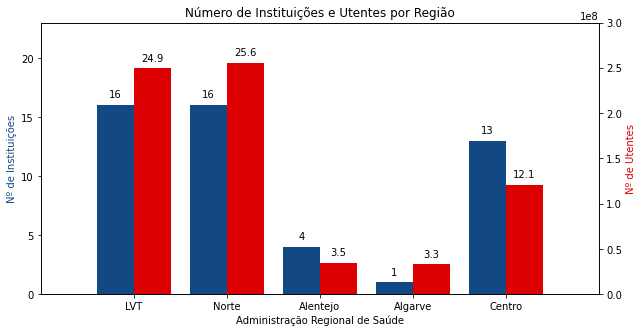

In [32]:
df_num_inst = df_hosp[['Região', 'Instituição']].groupby('Região').nunique()
df_num_inst['Utentes'] = df_utentes.groupby("Região").sum()["Utentes Inscritos CSP"]
df_num_inst.index = df_num_inst.index.str.replace(r"Região de Saúde (?:do )?", "")
display(df_num_inst)

bar_width = 0.4
label_scale = 0.02
height_inst = 23
height_utentes = 3e8
color_inst = '#124984'
color_utentes = '#DD0000'

ax = df_num_inst['Instituição'].plot(kind='bar', width=-bar_width, align="edge", color=color_inst, figsize=(10,5))
ax.set_title('Número de Instituições e Utentes por Região');
ax.set_ylabel('Nº de Instituições', color=color_inst);
ax.set_xlabel('Administração Regional de Saúde');
ax.set_ylim(0, height_inst)
ax.set_xlim(-1, 5)

for bar, value in zip(ax.patches, df_num_inst.Instituição.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + label_scale * height_inst,
            value, ha='center', va='bottom')

ax2 = ax.twinx()
ax2.set_ylim(0, height_utentes)
ax2.set_ylabel('Nº de Utentes', color=color_utentes)
ax2.bar(df_num_inst.index, df_num_inst["Utentes"], color=color_utentes, width=bar_width, align="edge")

for bar, value in zip(ax2.patches, df_utentes.groupby("Região").sum()["Utentes Inscritos CSP"].values):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + label_scale * height_utentes,
             round(value / 1e7,1), ha='center', va='bottom')

ax.set_xticklabels(df_num_inst.index, rotation=0);

plt.show()

No geral, o nº de instituições em cada ARS parece adequado ao nº de utentes inscritos em Cuidados de Saúde Primários pertencentes a cada região.

### 2.C. Distribuição das consultas por instituição

Para obter uma primeira ideia dos dados iremos analisar a variabilidade do número de consultas em cada instituição e região:

In [5]:
df_grouped = df_hosp.groupby(['Região','Instituição']).agg({'Período' : ['min', 'max', 'count'],
                                               'Nº Consultas Médicas Total':['sum', 'min', 'max', 'mean','std']}).copy()
df_grouped

Período  \
                                                                                    min   
Região                      Instituição                                                   
Região de Saúde LVT         Centro Hospitalar Barreiro/Montijo, EPE             2013-01   
                            Centro Hospitalar Médio Tejo, EPE                   2013-01   
                            Centro Hospitalar Psiquiátrico de Lisboa            2013-01   
                            Centro Hospitalar Universitário Lisboa Central,...  2013-01   
                            Centro Hospitalar Universitário de Lisboa Norte...  2013-01   
                            Centro Hospitalar de Lisboa Ocidental, EPE          2013-01   
                            Centro Hospitalar de Setúbal, EPE                   2013-01   
                            Centro Hospitalar do Oeste, EPE                     2013-01   
                            Hospital Distrital de Santarém, EPE                 2013-01   
                            Hospital Garcia de Orta, EPE                        2013-01   
                            Hospital Professor Doutor Fernando Fonseca, EPE     2013-01   
                            Hospital de Cascais, PPP                            2013-01   
                            Hospital de Loures, PPP                             2013-01   
                            Hospital de Vila Franca de Xira, EPE                2021-06   
                            Hospital de Vila Franca de Xira, PPP                2013-01   
                            Instituto Gama Pinto                                2013-01   
                            Instituto Português Oncologia de Lisboa, EPE        2013-01   
Região de Saúde Norte       Centro Hospitalar Entre Douro e Vouga, EPE          2013-01   
                            Centro Hospitalar Póvoa de Varzim/Vila do Conde...  2013-01   
                            Centro Hospitalar Trás-os-Montes e Alto Douro, EPE  2013-01   
                            Centro Hospitalar Tâmega e Sousa, EPE               2013-01   
                            Centro Hospitalar Universitário de São João, EPE    2013-01   
                            Centro Hospitalar Universitário do Porto, EPE       2013-01   
                            Centro Hospitalar Vila Nova de Gaia/Espinho, EPE    2013-01   
                            Centro Hospitalar do Alto Ave, EPE                  2013-01   
                            Centro Hospitalar do Médio Ave, EPE                 2013-01   
                            Hospital Santa Maria Maior, EPE                     2013-01   
                            Hospital da Senhora da Oliveira, Guimarães, EPE     2015-01   
                            Hospital de Braga, EPE                              2019-09   
                            Hospital de Braga, PPP                              2013-01   
                            Hospital de Magalhães Lemos, EPE                    2013-01   
                            Instituto Português Oncologia do Porto, EPE         2013-01   
                            Unidade Local de Saúde de Matosinhos, EPE           2013-01   
                            Unidade Local de Saúde do Alto Minho, EPE           2013-01   
                            Unidade Local de Saúde do Nordeste, EPE             2013-01   
Região de Saúde do Alentejo Hospital Espírito Santo de Évora, EPE               2013-01   
                            Unidade Local de Saúde do Baixo Alentejo, EPE       2013-01   
                            Unidade Local de Saúde do Litoral Alentejano, EPE   2013-01   
                            Unidade Local de Saúde do Norte Alentejano, EPE     2013-01   
Região de Saúde do Algarve  Centro Hospitalar Universitário do Algarve,EPE      2013-01   
Região de Saúde do Centro   Centro Hospitalar Tondela-Viseu, EPE                2013-01   
                            Centro Hospitalar Universitário Cova da Beira, E

Da análise desta tabela observamos:

* Os dados são entre Janeiro de 2013 e Julho de 2021, mas nem todas as instituições têm todos os meses (103 registos)

In [6]:
df_grouped[df_grouped.loc[:, ('Período', 'count')] != 103]

Período  \
                                                                               min   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2021-06   
                          Hospital de Vila Franca de Xira, PPP             2013-01   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE               2013-01   
                          Hospital da Senhora da Oliveira, Guimarães, EPE  2015-01   
                          Hospital de Braga, EPE                           2019-09   
                          Hospital de Braga, PPP                           2013-01   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2013-01   
                          Hospital José Luciano de Castro                  2013-01   

                                                                                    \
                                                                               max   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2021-07   
                          Hospital de Vila Franca de Xira, PPP             2021-05   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE               2014-12   
                          Hospital da Senhora da Oliveira, Guimarães, EPE  2021-07   
                          Hospital de Braga, EPE                           2021-07   
                          Hospital de Braga, PPP                           2019-08   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2021-05   
                          Hospital José Luciano de Castro                  2014-12   

                                                                                 \
                                                                          count   
Região                    Instituição                                             
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE                2   
                          Hospital de Vila Franca de Xira, PPP              101   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE                 24   
                          Hospital da Senhora da Oliveira, Guimarães, EPE    79   
                          Hospital de Braga, EPE                             23   
                          Hospital de Braga, PPP                             80   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                101   
                          Hospital José Luciano de Castro                    24   

                                                                          Nº Consultas Médicas Total  \
                                                                                                 sum   
Região                    Instituição                                                                  
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE                                164879   
                          Hospital de Vila Franca de Xira, PPP                               7777167   
Região de Saúde Norte     Centro Hospitalar do Alto Ave, EPE                                 3308126   
                          Hospital da Senhora da Oliveira, Guimarães, EPE                   10636758   
                          Hospital de Braga, EPE                                             5644537   
                          Hospital de Braga, PPP                                            18142017   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                                  925008   
                          Hospital José Luciano de Castro                                     163011   

                                                                                  \
                                      

Dado que vários hospitais mudaram de nome durante esta janela temporal, vamos uniformizar os seus nomes para os nomes atuais.

In [7]:
old_name_map = {i:i for i in df_hosp["Instituição"].unique()}

old_name_map.update({
    "Hospital de Vila Franca de Xira, PPP": "Hospital de Vila Franca de Xira, EPE",
    "Centro Hospitalar do Alto Ave, EPE": "Hospital da Senhora da Oliveira, Guimarães, EPE",
    "Hospital de Braga, PPP": "Hospital de Braga, EPE"
})

df_hosp["Instituição"] = df_hosp["Instituição"].map(old_name_map)


df_grouped = df_hosp.groupby(['Região','Instituição']).agg({
    'Período' : ['min', 'max', 'count'],
    'Nº Consultas Médicas Total':['sum', 'min', 'max', 'mean','std']}).copy()

df_grouped.loc[
    (["Região de Saúde LVT", "Região de Saúde Norte", "Região de Saúde do Centro"], 
     ["Hospital de Vila Franca de Xira, EPE", "Hospital de Vila Franca de Xira, PPP",
      "Centro Hospitalar do Alto Ave, EPE", "Hospital da Senhora da Oliveira, Guimarães, EPE",
      "Hospital de Braga, PPP", "Hospital de Braga, EPE",
      "Hospital Arcebispo João Crisóstomo",
      "Hospital José Luciano de Castro"]), :]

Período  \
                                                                               min   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2013-01   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE  2013-01   
                          Hospital de Braga, EPE                           2013-01   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2013-01   
                          Hospital José Luciano de Castro                  2013-01   

                                                                                    \
                                                                               max   
Região                    Instituição                                                
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             2021-07   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE  2021-07   
                          Hospital de Braga, EPE                           2021-07   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo               2021-05   
                          Hospital José Luciano de Castro                  2014-12   

                                                                                 \
                                                                          count   
Região                    Instituição                                             
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE              103   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE   103   
                          Hospital de Braga, EPE                            103   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                101   
                          Hospital José Luciano de Castro                    24   

                                                                          Nº Consultas Médicas Total  \
                                                                                                 sum   
Região                    Instituição                                                                  
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE                               7942046   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE                   13944884   
                          Hospital de Braga, EPE                                            23786554   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                                  925008   
                          Hospital José Luciano de Castro                                     163011   

                                                                                  \
                                                                             min   
Região                    Instituição                                              
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE              9231   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE  19613   
                          Hospital de Braga, EPE                           32909   
Região de Saúde do Centro Hospital Arcebispo João Crisóstomo                 922   
                          Hospital José Luciano de Castro                   1023   

                                                                                   \
                                                                              max   
Região                    Instituição                                               
Região de Saúde LVT       Hospital de Vila Franca de Xira, EPE             167371   
Região de Saúde Norte     Hospital da Senhora da Oliveira, Guimarães, EPE  264654   
                          Hospital de Braga, EPE                           472311   
Região de Saúde 

Na tabela acima, podemos concluir que os nomes foram corretamente uniformizados (103 registos), faltando dados apenas para dois hospitais cujos dados deixaram de ser disponibilizados no Portal Transparência do SNS (Hospital Arcebispo João Crisóstomo e Hospital José Luciano de Castro).

Continuando com a nossa análise:
* O número mínimo de consultas médicas é muito menor do que a média - isto acontece de forma consistente para todas as instituições

In [8]:
(df_grouped.loc[:, ("Nº Consultas Médicas Total", "min")]/df_grouped.loc[:, ("Nº Consultas Médicas Total", "mean")]).max()

0.16392377656216298

* O desvio padrão é muito maior que o valor mínimo - isto acontece de forma consistente para todas as instituições

In [9]:
(df_grouped.loc[:, ("Nº Consultas Médicas Total", "std")]/df_grouped.loc[:, ("Nº Consultas Médicas Total", "min")]).min()

3.233822315831222

Focando num único hospital, por exemplo o **IPO de Lisboa**:
  * O IPO tem <a href="https://www.ipolisboa.min-saude.pt/ipo/conheca-nos/">360 médicos</a>
  * Nem todos os médicos do IPO trabalham em exclusividade, nem dão consultas todos os dias
  * Os médicos têm férias, outros deveres além das consultas e têm de ter algumas pausas durante o dia
  * O máximo mensal para o IPO em Lisboa é de 274.815 consultas de oncologia num mês, com uma média 22 dias úteis por mês dá mais de 34 consultas por médico por dia, o que parece claramente excessivo.

In [10]:
(df_grouped.loc[("Região de Saúde LVT", "Instituto Português Oncologia de Lisboa, EPE"),
               ("Nº Consultas Médicas Total", "max")],
round(df_grouped.loc[("Região de Saúde LVT", "Instituto Português Oncologia de Lisboa, EPE"),
               ("Nº Consultas Médicas Total", "max")] / 360 / 22, 2))

(274815, 34.7)

  * Já o mínimo de 20.678 dá cerca de 3 consultas por médico por dia, o que faz mais sentido atendendo a que nem todos os médicos dão consultas todos os dias, e que algumas consultas são bastante demoradas.

In [11]:
(df_grouped.loc[("Região de Saúde LVT", "Instituto Português Oncologia de Lisboa, EPE"),
               ("Nº Consultas Médicas Total", "min")],
round(df_grouped.loc[("Região de Saúde LVT", "Instituto Português Oncologia de Lisboa, EPE"),
               ("Nº Consultas Médicas Total", "min")] / 360 / 22))

(20678, 3)

Vamos olhar para os dados de uma instituição a ver se conseguimos identificar a causa:

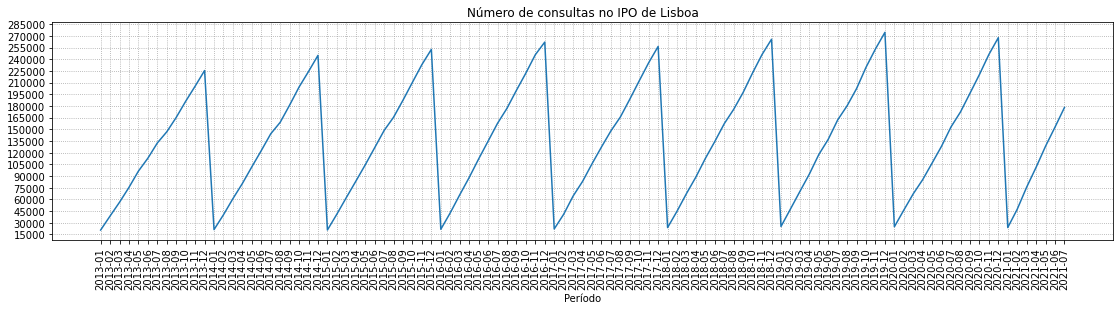

In [12]:
instituição = 'Instituto Português Oncologia de Lisboa, EPE'
df = df_hosp[df_hosp.Instituição==instituição].sort_values('Período').set_index('Período', drop=False)
ax=df['Nº Consultas Médicas Total'].plot(figsize=(19, 4));
ax.set_xticks(range(len(df["Período"])))
ax.set_xticklabels(df["Período"], rotation=90);
ax.set_title('Número de consultas no IPO de Lisboa');
ax.yaxis.set_major_locator(MultipleLocator(15000))
ax.grid(which='major', color='#A0A0A0', linestyle=':')

Analisando o gráfico compreende-se que:

* O número de consultas mensal é cumulativo ao longo de cada ano
* O total de consultas em 2020 no IPO mostra apenas um ligeiro decréscimo face ao ano de 2019

Vamos transpor a análise efetuada ao IPO para todas as instituições, para avaliar a alteração do número de consultas médicas no ano de 2020 de forma mais objetiva.

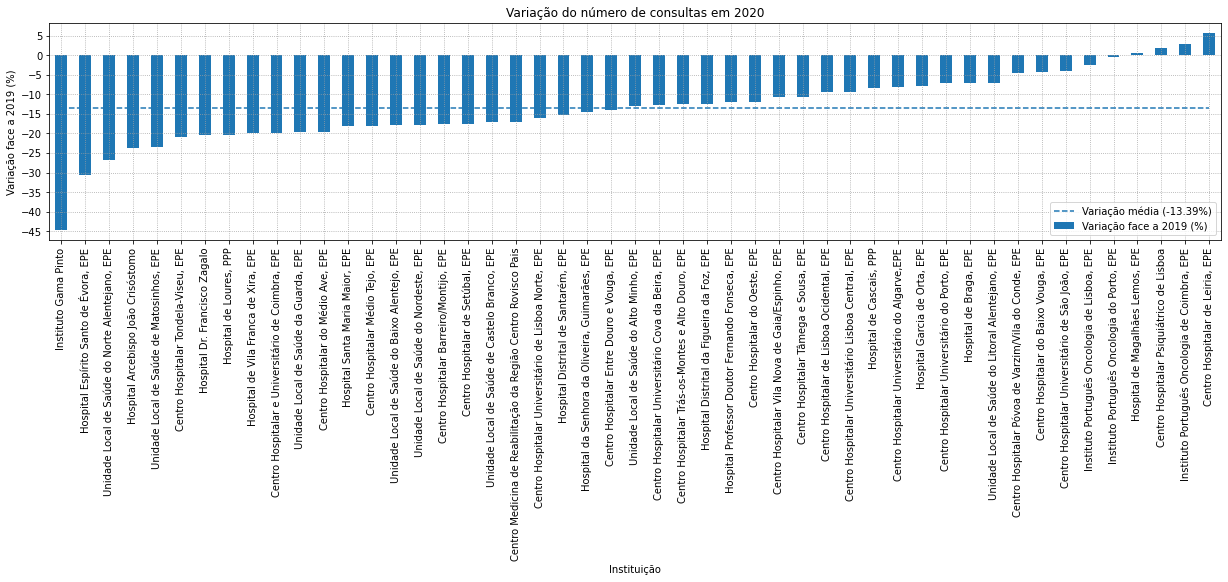

In [13]:
nome = 'Variação face a 2019 (%)'
df = df_hosp.copy()

df = df_hosp[['Período','Nº Consultas Médicas Total','Instituição']].copy().set_index('Instituição')
df = 100*(df[(df.Período=='2020-12')][['Nº Consultas Médicas Total']] - df[df.Período=='2019-12'][['Nº Consultas Médicas Total']])/df[df.Período=='2020-12'][['Nº Consultas Médicas Total']]
df.columns = [nome]

df.sort_values(by=nome, inplace=True)
ax = df.plot(figsize=(21,4), kind='bar')
ax.set_title('Variação do número de consultas em 2020');
ax.set_ylabel('Variação face a 2019 (%)');
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.index, rotation=90);
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
média =  np.ones(len(df.index))*df[nome].mean()
ax.plot(média, label=f"Variação média ({média[0]:.2f}%)", linestyle='--');
ax.legend(loc='lower right');

Há um decréscimo médio de 13.39% do número de consultas, embora o impacto seja extremamente variado, desde o Instituto Gama Pinto que fez cerca de metade das consultas que no ano anterior, até ao CH Leiria que prestou mais cerca de 5% de consultas que no ano anterior.

### 2.D. Evolução mensal do número de consultas

Construir um novo `DataFrame` com as diferenças para o mês anterior, exceto em Janeiro quando devemos manter apenas o valor indicado. Para facilitar vamos focar a atenção nas instituições que têm dados para todos os meses

In [14]:
df_mes = df_hosp.copy()
df_mes['Mês'] = pd.to_datetime(df_mes['Período'] , format='%Y-%m')  
df_mes['Dia'] = pd.to_datetime(df_mes['Periodo_format_2'] , format='%Y/%m/%d')

inst_nmonths = df_mes[['Instituição','Mês']].groupby('Instituição').nunique()
all_inst = len(inst_nmonths)
inst_nmonths = inst_nmonths[inst_nmonths.Mês == inst_nmonths.Mês.max()].index
df_mes = df_mes[df_mes.Instituição.isin(inst_nmonths)]
print(f"Existem {all_inst} instituições das quais vamos usar as \
{df_mes.Instituição.nunique()} que têm dados para todos os meses.")

Existem 50 instituições das quais vamos usar as 48 que têm dados para todos os meses.


Para estas instituições vamos olhar para as consultas desde 2019 e ver se notamos algum padrão nas consultas mensais.

O código parece ser um pouco complexo, mas a ideia geral é acessível:
* Começamos por criar `pivot_mes` que tem:
  * linhas que representam cada instituição com presença de dados em todos os meses
  * colunas cujos nomes são datas, ex: 2019-01-01, ..., 2021-07-01
  * os valores são o número de consultas nessa instituição acumuladas anualmente até esse mês
* Vamos usá-lo para  criar `df_inst` cujos valores indicam o número de consultas realizadas nessa instituição apenas nesse mês, e para isso:
  * Substituímos cada mês pela diferença entre o valor atual e o valor anterior, efetivamente desfazendo os valores acumulados identificados anteriormente
  * Em janeiro de cada ano repomos o valor que estava originalmente em `pivot_mes` porque os acumulados recomeçam anualmente em janeiro

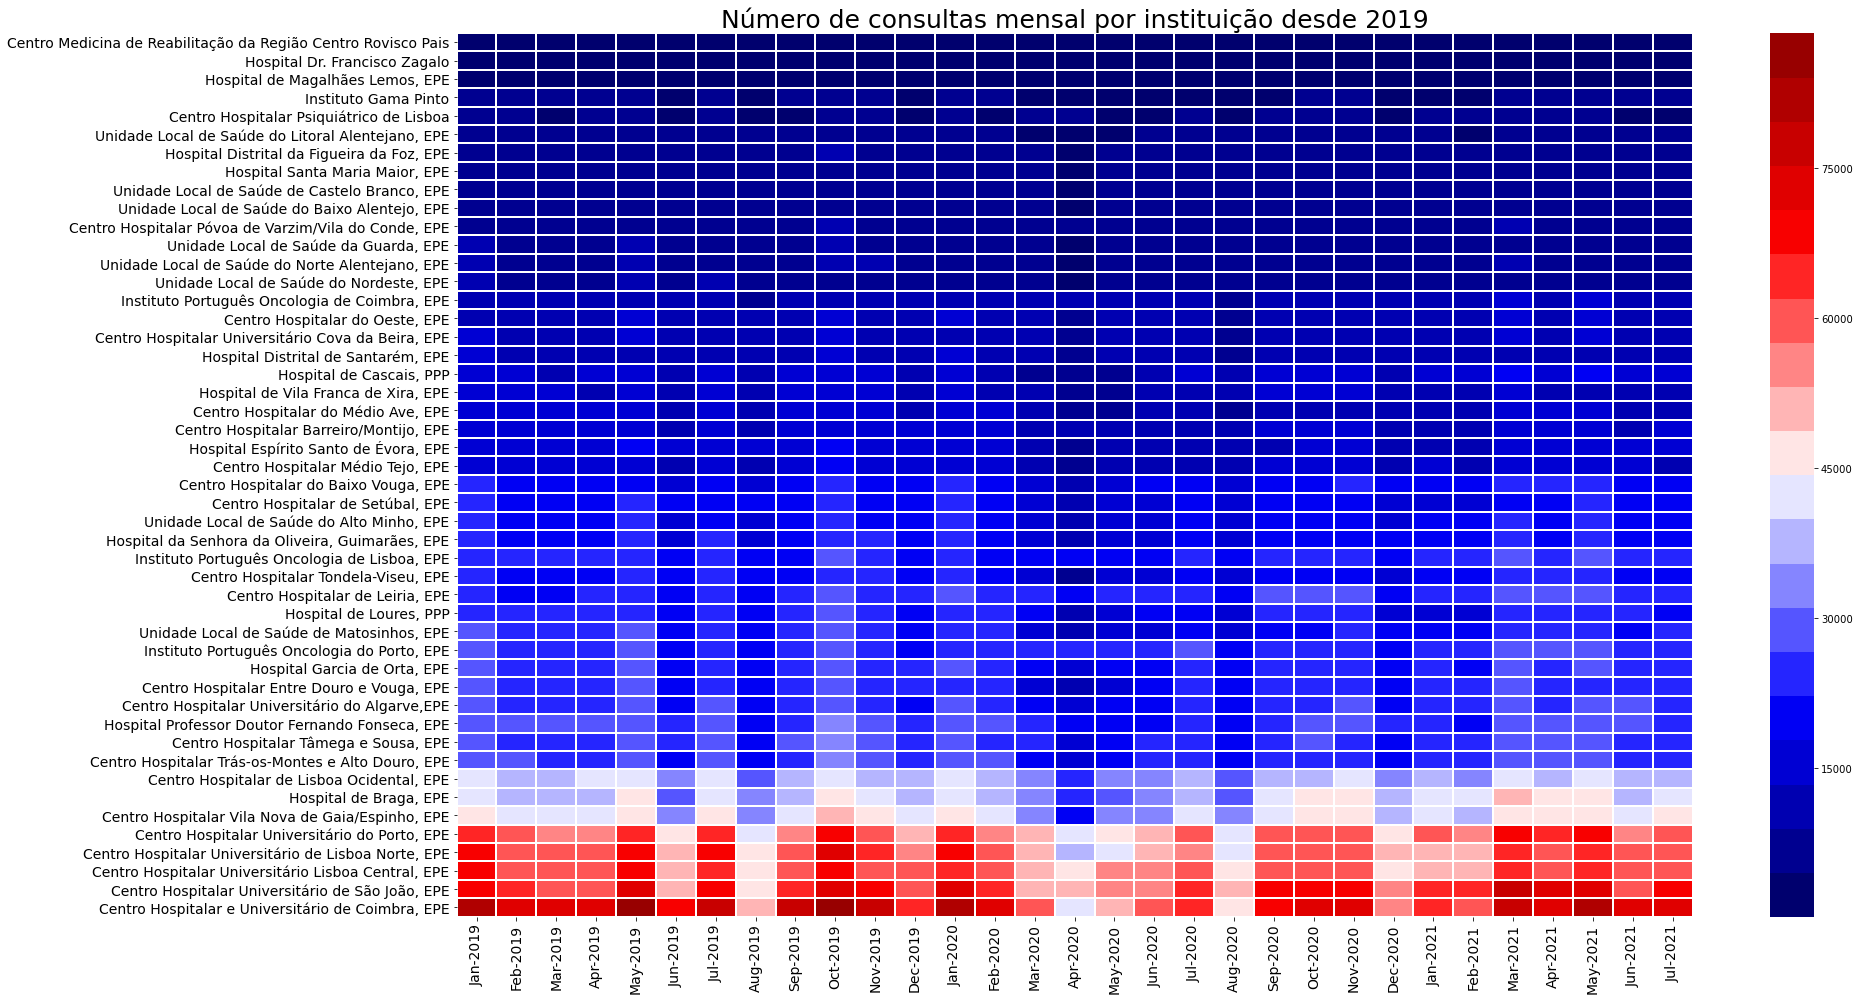

In [76]:
pivot_mes = pd.pivot_table(df_mes, values='Nº Consultas Médicas Total',
                           index=['Instituição'], columns=['Dia'], aggfunc='sum')
df_inst = pivot_mes.T.diff()
first_index = ((df_inst.index >= '2019-01-01') == False).sum()
df_inst = df_inst.where(df_inst>1).T.iloc[:, first_index:]
for i in range(0, len(df_inst.columns), 12):
    df_inst.iloc[:, i] = pivot_mes.iloc[:, first_index+i]

df_inst.sort_values(by='2019-01-01', inplace=True)
cmap = sns.color_palette('seismic', 20)
fig, ax = plt.subplots(figsize=(28, 14))
ax = sns.heatmap(df_inst, square=False, annot=False, cmap=cmap3, linewidths=1)
ax.set_yticklabels(df_inst.index, rotation=0, fontsize=14);
ax.set_xticklabels(get_month_labels_from_date_columns(df_inst), rotation=90, fontsize=14);
ax.set_xlabel(''); ax.set_ylabel('');
ax.set_title("Número de consultas mensal por instituição desde 2019", fontsize=25);
plt.tight_layout()

Identificam-se: 
* menos consultas em Junho e Agosto (2019 e 2020), provavelmente efeitos das férias nos feriados de Junho e em Agosto;
* Abril de 2020 foi um mês com poucas consultas especialmente nos hospitais que prestam mais consultas

Os períodos de março, abril e maio de 2020 registam poucas consultas, provavelmente constituindo uma consequência do primeiro Estado de Emergência implementado. No final de 2020 verifica-se também uma redução destacada quando se compara com o período homólogo de 2019, sendo mais significativa no “Centro Hospitalar Universitário de São João, EPE” e “Centro Hospitalar Universitário de Coimbra, EPE”.


Vamos ver também comparação dos totais de consultas mensais nos 3 últimos anos: 

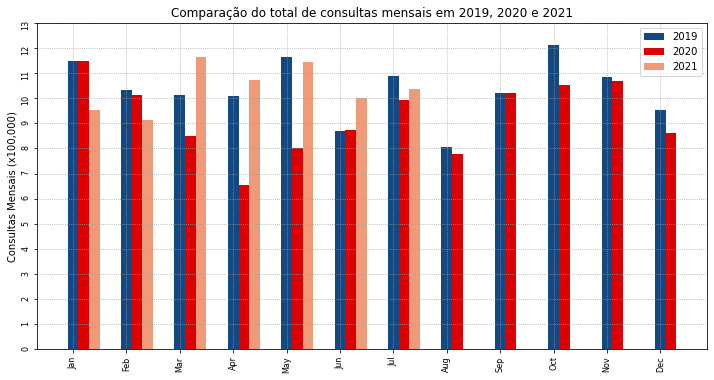

In [31]:
total_mensal = df_inst.sum(axis=0)
total_19 = total_mensal.iloc[:12]
total_20 = total_mensal.iloc[12:24]
total_21 = total_mensal.iloc[24:36]
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(range(0,120,10),total_19.values, width=2, label="2019", color="#124984")
ax.bar(range(2,122,10),total_20.values, width=2, label="2020", color="#dd0000")
ax.bar(range(4,len(total_21)*10+4,10),total_21.values, width=2, label="2021", color="#ef9b7a")
ax.set_xticks(range(0,120,10))
ax.set_xticklabels(month_abbr[1:], rotation=90, fontsize = 8);

step = 100000 
lim = int(step*(2+total_mensal.max()//step))
ticks = list(range(0,lim,step))
ax.set_yticks(ticks)
ax.yaxis.set_major_locator(FixedLocator(ticks))
ax.grid(which='major', color='#A0A0A0', linestyle=':')
ax.set_yticklabels([f"{i//step:,}" for i in ticks], rotation=90, fontsize = 8);
ax.set_ylabel(f'Consultas Mensais (x{step:,})')
ax.legend()
ax.set_title("Comparação do total de consultas mensais em 2019, 2020 e 2021");

As maiores diferenças entre o número de consultas mensais entre 2019 e 2020 registam-se nos meses de março, abril e maio, coincidindo com períodos de Estado de Emergência nacional. O Estado de Emergência foi também implementado nos meses de Novembro e Dezembro de 2020 porém, verifica-se que a redução no nº de consultas não é tão significativa.
Por outro lado, em 2021 observa-se a recuperação progressiva das consultas face aos valores anteriores à situação pandémica.

## 3. Conclusão

Demonstração da utilização dos <a href="https://transparencia.sns.gov.pt/explore/?sort=title">dados disponibilizados</a> pelo <a href="https://www.sns.gov.pt/">Serviço Nacional de Saúde</a>.

O objectivo deste notebook é:

* Mostrar como obter dados utilizando a <a href="https://transparencia.sns.gov.pt/api/v1/console/datasets/1.0/search/">API</a> disponibilizada pela área de <a href="https://www.sns.gov.pt/transparencia/">Transparência do Portal do Serviço Nacional de Saúde</a>;
* Ilustrar o processo de limpeza e visualização destes dados;
* Explorar o impacto do  COVID-19 na sociedade em geral e em particular na prestação de cuidados de saúde em Portugal com questões como:
    * Como foi afectada a prestação de cuidados de oncologia?
    * Como foram afectadas as cirugias? 
    * Que impacto teve na mortalidade total em comparação com outros anos?
    * Qual o impacto da covid nas consultas médicas hospitalares e consultas em Telemedicina?
    * Como evoluiu a mobilidade dos portugueses com o aumento da fadiga pandémica? 
    * Qual o peso das condições meteorológicas na mobilidade?    
    * ...